In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')


In [13]:
class consts:
    c = 3e8
    e = 1.6e-19
    m_e = 9.1e-31 # kg
    h = 6.626e-34 # J * s
    hbar = 1.054e-34 # J * s
class setup:
    dummy = 0


### Dynamic

In [247]:
# Из фоток (см. ms_2.51 и тд.)

dyn = {
    'V' : (2.51,    2.77,    2.97),
    'V_min' : (6.8,     7.1,     6.5),
    'V_max' : (2.1,     2.2,     2),
    'V_br'  : (13.1,    12.3,    11.0),
}

def get_l_U0(V_max, V_min, V_max_err = 0, V_min_err = 0):
    l = consts.h * np.sqrt(5/32) / np.sqrt(consts.m_e * consts.e * (V_min - V_max)) # лабник формула (10)
    epsilon_diff = np.sqrt(V_max_err**2 + V_min_err**2) / abs(V_max - V_min)
    l_err = l * 0.5 * epsilon_diff
    print(f"l = ({l * 1e10:.1f} +- {l_err * 1e10:.2f}) Angstrem")

    #U0 = 4/5 * V_min - 9/5 * V_max
    #print(f"U0 = {U0} eV")
    return l * 1e10, l_err * 1e10

def export_MMM( data, V_error, name):

    arr_l = []
    arr_l_err = []
    arr_V_err = []

    for i in range(len(data)):
        __l, __l_err = get_l_U0(data['V_max'][i], data['V_min'][i], V_error, V_error)

        arr_V_err.append(V_error)
        arr_l.append(__l)
        arr_l_err.append(__l_err)

    data.insert(4, 'dV', arr_V_err)
    data.insert(5, 'l', arr_l)
    data.insert(6, 'dl', arr_l_err)

    fmt = {
        ('V') : [r'$V, В$', '{:.1f}', 0],
        ('V_min') : [r'$V_{\text{min}}, В$', '{:.1f}', 0],
        ('V_max') : [r'$V_{\text{max}}, В$', '{:.1f}', 0],
        ('V_br') : [r'$V_{\text{break}}, В$', '{:.1f}', 0],
        ('dV') : [r'$\sigma_V, В$', '{:.1f}', 0],
        ('l') : [r'$l$, А', '{:.1f}', 0],
        ('dl') : [r'$\sigma_l$, А', '{:.1f}', 0],
    }

    tab = mipt.table(data, fmt)
    tab.to_latex(name)
    return data, tab


error = 3 / 5 * 2 #В, возьмем пару цен
dyn_data = pd.DataFrame(dyn)
d, tab = export_MMM(dyn_data, error, 'gen/tab-dyn.tex')


l = (3.2 +- 0.57) Angstrem
l = (3.1 +- 0.54) Angstrem
l = (3.2 +- 0.61) Angstrem


### Static

In [248]:
R = 100 # kOm

def get_data(filename):
    data = pd.read_excel(filename)
    fmt = {
        'V_ks(V)' : 'V_k',
        'V_a(mV)' : 'V_a',
    }

    data = mipt.map_excel(data, fmt)
    data['I'] = data['V_a'] / 100 # mkA
    return data

data1 = get_data('data/2.52V.xlsx').sort_values(by="V_k")
data2 = get_data('data/2.75V.xlsx').sort_values(by="V_k")

data1

# Для погрешностей используем последнюю цифру разряда. Т.к. там у нас значение скакало

df = data1

def export_df(df, name, costil):
    df.insert(1, 'dV_k', df['V_k'] * 0.0003 + 0.01)
    df.insert(3, 'dV_a', df['V_a'] * 0.0003 + 0.1)
    df.insert(5, 'dI', df['dV_a'] / 100)

    keys = [r'$V=2.52$, В', r'$V=2.75$, В']

    df = pd.concat([df], axis='columns', keys=[keys[costil]])

    fmt = {(key, 'V_k')  : [r'$V_{\text{катод}}$, В',  '{:.3f}'] for key in keys} \
        | {(key, 'dV_k') : [r'$\sigma_{V_{\text{катод}}}$, В',  '{:.3f}'] for key in keys} \
        | {(key, 'V_a')  : [r'$V_{\text{анод}}$, мВ',  '{:.2f}'] for key in keys} \
        | {(key, 'dV_a') : [r'$\sigma_{V_{\text{анод}}}$, мВ',  '{:.2f}'] for key in keys} \
        | {(key, 'I')    : [r'$I_{\text{анод}}$, мкА', '{:.4f}'] for key in keys} \
        | {(key, 'dI')   : [r'$\sigma_{I_{\text{анод}}}$, мкА',  '{:.4f}'] for key in keys}


    tab = mipt.table(df, fmt)
    tab.to_latex(name)
    
    
export_df(data1, 'gen/tab-2.52V.tex', costil=0)
export_df(data2, 'gen/tab-2.75V.tex', costil=1)

$V_{накала} = 2.52$ В
$V_{накала} = 2.75$ В


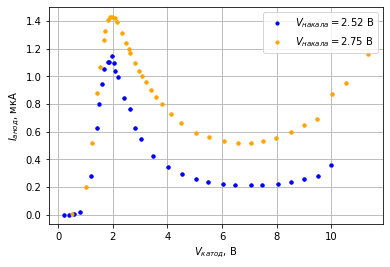

In [249]:
def process(data, label, color, drawmax=False, drawmin=False):
    print(label)
    x = np.array(data['V_k']) # V
    y = np.array(data['I'])   # mkA
    mipt.plot(x, y, func=None, color=color)

    plt.scatter(x, y, label=label, c = color, s=10)

    maxV = np.argmax(y[:len(y)//2])
    minV = np.argmin(y[len(y)//2:]) + len(y)//2
    if drawmax: plt.axvline(x[maxV], linestyle=':', c=color)
    if drawmin: plt.axvline(x[minV], linestyle=':', c=color)

    #print(f"V_max = {x[maxV]} V, V_min = {x[minV]} V")
    #print(f"I_max = {y[maxV]} mkA, I_min = {y[minV]} mkA")

    return x[maxV], x[minV]

V_max, V_min = process(data1, "$V_{накала} = 2.52$ В", 'blue')
#V_max_err = 0.1
#V_min_err = 0.2
#l, U0 = get_l_U0(V_max, V_min, V_max_err, V_min_err)

process(data2, "$V_{накала} = 2.75$ В", 'orange', drawmin=False)

plt.xlabel(r'$V_{катод}$, В')
plt.ylabel(r'$I_{анод}$, мкА')
plt.legend()
plt.grid()
plt.savefig('gen/static.pdf')


In [250]:
st = {
    'V' :     (2.52,    2.75),
    'V_min' : (7.1,     7.2),
    'V_max' : (2.0,     2.1),
    'V_br'  : (10,      11),
}

error = 1 #В
st_data = pd.DataFrame(st)
d, tab = export_MMM(st_data, error, 'gen/tab-st.tex')

l = (3.0 +- 0.42) Angstrem
l = (3.0 +- 0.42) Angstrem


In [251]:
# Потенциал ионизации
I = 10 + 2.5 # U_break + U_0 (=2.5 В по методичке)
I

12.5

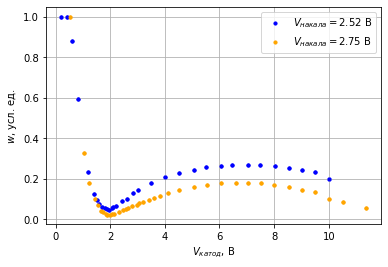

In [252]:
def probability(data, label, color, start, end=None):
    x = np.array(data['V_k'])
    y = np.array(data['I'])
    if end == None: end = len(x)
    x = np.array(x[start:end])    # V
    y = -np.log(0.6 * y[start:end]) # Этот 0.6 вообще никакого смысла не имеет (это я выбрал I_0). 
                                    # Просто, чтобы не проходило через отрицательные значения
    y = y / max(y)

    mipt.plot(x, y, func=None, color=color)
    plt.scatter(x, y, label=label, c = color, s=10)
    return None

probability(data1, "$V_{накала} = 2.52$ В", 'blue', start=0)
probability(data2, "$V_{накала} = 2.75$ В", 'orange', start=0)
plt.legend()
plt.grid()
plt.xlabel(r'$V_{катод}$, В')
plt.ylabel(r'$w$, усл. ед.')
plt.savefig(f'gen/probability.pdf')
plt.show()
